In [45]:
!pip install category_encoders

  Obtaining dependency information for category_encoders from https://files.pythonhosted.org/packages/1f/e2/495811f12b2e90753fff0e42a07adb0370a725de17cc23a579ac9d3ca67c/category_encoders-2.6.2-py2.py3-none-any.whl.metadata
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.9/9.9 MB 9.6 MB/s eta 0:00:000m eta 0:00:010:01:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.8/233.8 kB 13.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.8/81.8 kB 5.7 MB/s eta 0:00:00

[notice] A new release of pip is available: 23.2.1 -> 23.3
[notice] To update, run: python3.10 -m pip install --upgrade pip


In [44]:
import numpy as np
import sklearn
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score
from sklearn.naive_bayes import CategoricalNB
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import make_column_transformer

from sklearn import preprocessing

In [5]:
mashrooms = pd.read_csv('mushrooms.csv')

In [6]:
mashrooms.head()

,class,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,...,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
0,p,x,s,n,t,p,f,c,n,k,...,s,w,w,p,w,o,p,k,s,u
1,e,x,s,y,t,a,f,c,b,k,...,s,w,w,p,w,o,p,n,n,g
2,e,b,s,w,t,l,f,c,b,n,...,s,w,w,p,w,o,p,n,n,m
3,p,x,y,w,t,p,f,c,n,n,...,s,w,w,p,w,o,p,k,s,u
4,e,x,s,g,f,n,f,w,b,k,...,s,w,w,p,w,o,e,n,a,g


In [7]:
mushrooms_freq = []
props = mashrooms.drop(columns=['class']).columns

for p in props:
    result = mashrooms[['class', p]].groupby('class').value_counts(normalize=True).reset_index()
    result = result.rename(columns={p: 'p_data', 0: 'p_freq'})
    result['p_name'] = p
    mushrooms_freq.append(result)

mushrooms_freq = pd.concat(mushrooms_freq)

In [8]:
mushrooms_freq.head()

,class,p_data,p_freq,p_name
0,e,x,0.462928,cap-shape
1,e,f,0.379278,cap-shape
2,e,b,0.096008,cap-shape
3,e,k,0.054183,cap-shape
4,e,s,0.007605,cap-shape


In [9]:
def visualizePropsBar(props: list):
    for p in props:
        sns.catplot(x=p, data=mashrooms, hue='class', kind='count')

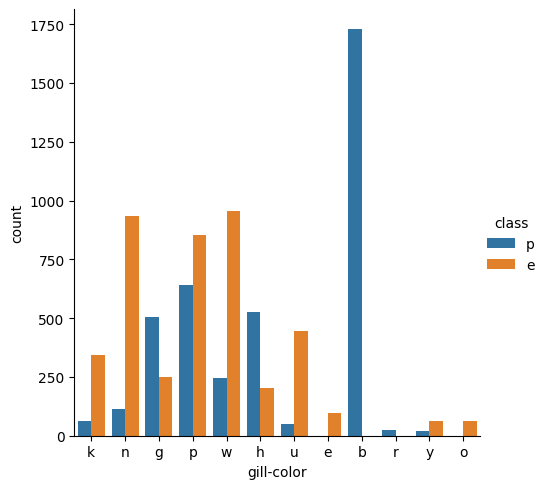

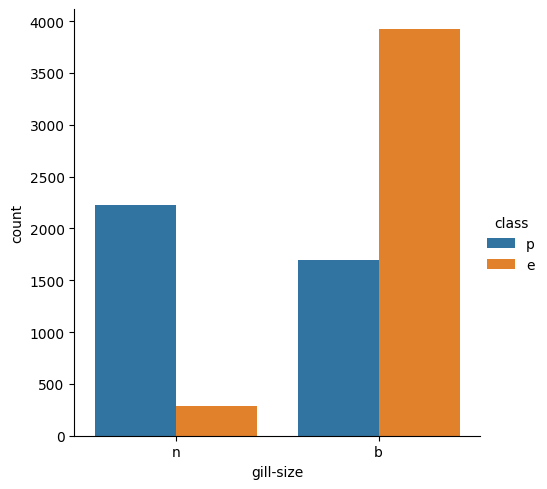

In [10]:
visualizePropsBar(['gill-color', 'gill-size'])

In [11]:
X = mashrooms.drop(columns='class')
y = mashrooms['class']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)

In [12]:
X_test

,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,stalk-shape,...,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
3493,f,y,g,t,n,f,c,b,u,t,...,s,p,w,p,w,o,p,n,v,d
1262,f,s,w,t,p,f,c,n,k,e,...,s,w,w,p,w,o,p,k,s,g
7747,b,s,g,f,n,f,w,b,w,e,...,k,w,w,p,w,t,p,w,n,g
2538,x,f,e,t,n,f,c,b,n,t,...,s,w,g,p,w,o,p,k,v,d
471,x,y,w,t,a,f,c,b,w,e,...,s,w,w,p,w,o,p,k,n,m
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1376,f,f,w,f,n,f,w,b,k,t,...,f,w,w,p,w,o,e,k,s,g
3186,f,y,g,t,n,f,c,b,u,t,...,s,g,w,p,w,o,p,k,v,d
4945,k,s,p,t,n,f,c,b,w,e,...,s,e,e,p,w,t,e,w,c,w
3030,f,y,g,t,n,f,c,b,w,t,...,s,g,w,p,w,o,p,k,v,d


In [13]:
class BayesFreq:
    def __init__(self, X, y):
        self.X = X
        self.y = y
        self.probs = None
    
    def train(self, _lambda=0):
        probs = []
        for c in y.unique():
            prob_class = []
            for feature in X.columns:
                prob_feature = {}
                x = X[feature][y == c]
                k = len(X[feature].unique())
                for i in X[feature].unique():
                    prob_feature[i] = (x[x == i].count() + _lambda) / (x.count() + _lambda * k)
                prob_class.append(prob_feature)
            probs.append(prob_class)
        self.probs = np.array(probs)

        
    def predict(self, X, feature):
        y_pred = []
        idx = X.columns.get_loc(feature)
        prob0_feature = self.probs[0][idx]
        prob1_feature = self.probs[1][idx]
        p0 = y[y == 'e'].count() / y.count()
        p1 = y[y == 'p'].count() / y.count()
        for k in (X[feature]):
            y_pred.append('e' if p0 * prob0_feature[k] < p1 * prob1_feature[k] else 'p')
        return np.array(y_pred)

In [14]:
model = BayesFreq(X_train, y_train)
model.train()

In [15]:
results = {
    'column_name': list(),
    'acc_test': list()
}
for f in X_test.columns:
    results['column_name'].append(f)
    results['acc_test'].append(accuracy_score(y_test, model.predict(X_test,f)))

In [16]:
pd.DataFrame(results)

,column_name,acc_test
0,cap-shape,0.531891
1,cap-surface,0.591570
2,cap-color,0.577769
3,bruises,0.741887
4,odor,0.982842
5,gill-attachment,0.504662
6,gill-spacing,0.611712
7,gill-size,0.763894
8,gill-color,0.812383
9,stalk-shape,0.545692


In [17]:
X_c = X.copy()
y_c = y.copy()
for i in X_c:
    X_c[i]=LabelEncoder().fit_transform(X_c[i])
y_c = LabelEncoder().fit_transform(y_c)

X_train, X_test, y_train, y_test = train_test_split(X_c, y_c, test_size=0.25, random_state=42)

In [18]:
model = sklearn.naive_bayes.CategoricalNB().fit(X_train,y_train)
print('test',accuracy_score(y_test, model.predict(X_test)))
print('train',accuracy_score(y_train, model.predict(X_train)))

test 0.9487936976858691
train 0.954045626128344


## Bayes from scratch

In [19]:
X = mashrooms.drop(columns='class')
y = mashrooms['class']

In [20]:
def get_prob_col(column,j, alpha = 0):
    prob = {}
    x = X[column]
    x = x[y == j]
    k = len(X[column].unique())
    for i in X[column].unique():
        prob[i] = (x[x == i].count() + alpha) / (x.count() + alpha * k)
    return prob

def get_prob(j,alpha = 0): 
    prob = {}
    for col in X.columns:
        prob[col] = (get_prob_col(col,j,alpha))
    return prob

def predict(X, alpha = 0):
    prob0 = get_prob('e',alpha= alpha)
    prob1 = get_prob('p',alpha = alpha)
    p0 = y[y == 'e'].count() / y.count()
    p1 = y[y == 'p'].count() / y.count()
    y_pred = []
    for i in range(len(X)):
        prod0 = p0
        prod1 = p1
        for col in X.columns:
            prod0 *= prob0[col][X[i:i+1][col].values[0]]
            prod1 *= prob1[col][X[i:i+1][col].values[0]] 
        if p0 * prod0 < p1 * prod1:
            y_pred.append('p') 
        else:
            y_pred.append('e')
    return y_pred

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [22]:
print('train:',accuracy_score(predict(X_train, alpha= 1), y_train))
print('test:',accuracy_score(predict(X_test, alpha= 1), y_test))

train: 0.9566715903495815
test: 0.9537173806006893


In [23]:
# 5

In [81]:
X = mashrooms.drop(columns=['class'])
y = mashrooms['class']

In [82]:
from sklearn.linear_model import LogisticRegression
import warnings
from category_encoders.target_encoder import TargetEncoder

with warnings.catch_warnings():
    warnings.simplefilter(action='ignore', category=FutureWarning)

0.9977843426883308
[6.28637927e-03 9.97486193e-01 9.97389840e-01 ... 9.99988036e-01
 7.51052250e-04 9.99984100e-01]


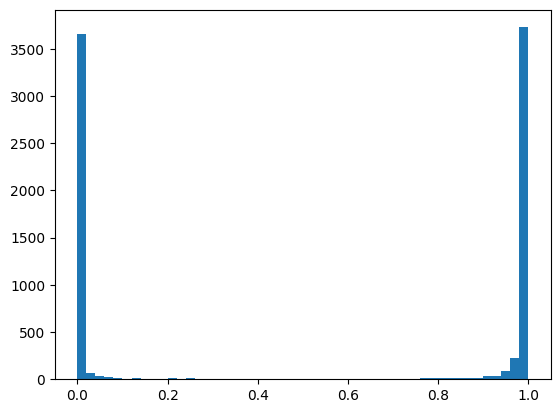

In [83]:
model = LogisticRegression()
X_c = X.copy()
y_c = y.copy()
y_c = y_c.apply(lambda x: 0 if x=='p' else 1)

encoder = TargetEncoder()
for i in X_c:
    X_c[i]=TargetEncoder().fit_transform(X_c[i], y_c)
model.fit(X_c, y_c)
probs = model.predict_proba(X_c)[:,1]
print(accuracy_score(y_c, model.predict(X_c)))
print(probs) 
plt.hist(probs, 50)
plt.show()

In [84]:
X_c

,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,stalk-shape,...,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
0,0.532823,0.447574,0.553415,0.815166,2.917126e-11,0.507455,0.441574,0.114650,0.843137,0.459613,...,0.688817,0.616487,0.616788,0.517971,0.506815,0.491453,0.794355,0.880342,0.705128,0.260870
1,0.532823,0.447574,0.373134,0.815166,1.000000e+00,0.507455,0.441574,0.698503,0.843137,0.459613,...,0.688817,0.616487,0.616788,0.517971,0.506815,0.491453,0.794355,0.886179,1.000000,0.655493
2,0.893805,0.447574,0.692308,0.815166,1.000000e+00,0.507455,0.441574,0.698503,0.893130,0.459613,...,0.688817,0.616487,0.616788,0.517971,0.506815,0.491453,0.794355,0.886179,1.000000,0.876712
3,0.532823,0.463625,0.692308,0.815166,2.917126e-11,0.507455,0.441574,0.114650,0.893130,0.459613,...,0.688817,0.616487,0.616788,0.517971,0.506815,0.491453,0.794355,0.880342,0.705128,0.260870
4,0.532823,0.447574,0.560870,0.306655,9.659864e-01,0.507455,0.914634,0.698503,0.843137,0.562500,...,0.688817,0.616487,0.616788,0.517971,0.506815,0.491453,0.363112,0.886179,1.000000,0.655493
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8119,0.275362,0.447574,0.553415,0.306655,9.659864e-01,0.914286,0.441574,0.698503,0.743879,0.459613,...,0.688817,1.000000,1.000000,0.517971,0.999759,0.491453,0.794355,0.972368,0.847059,0.288462
8120,0.532823,0.447574,0.553415,0.306655,9.659864e-01,0.914286,0.441574,0.698503,0.743879,0.459613,...,0.688817,1.000000,1.000000,0.517971,0.999759,0.491453,0.794355,0.972368,0.295050,0.288462
8121,0.506345,0.447574,0.553415,0.306655,9.659864e-01,0.914286,0.441574,0.698503,0.893130,0.459613,...,0.688817,1.000000,1.000000,0.517971,0.999759,0.491453,0.794355,0.972368,0.847059,0.288462
8122,0.275362,0.463625,0.553415,0.306655,0.000000e+00,0.507455,0.441574,0.114650,0.000000,0.562500,...,0.062500,0.616487,0.616788,0.517971,0.506815,0.491453,0.363112,0.241206,0.295050,0.288462


1.0
[1.00000000e+00 8.87982121e-04 6.43761906e-04 ... 4.76943513e-09
 9.96594313e-01 1.31882191e-08]


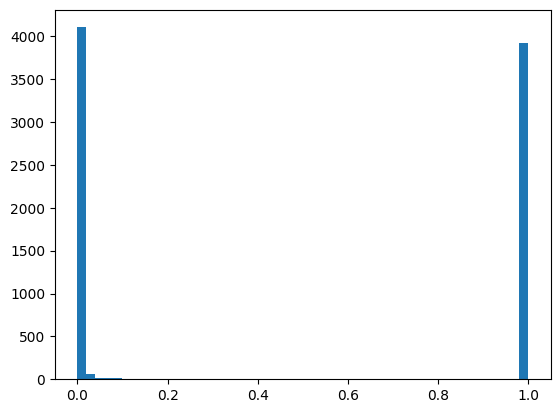

In [86]:
model = LogisticRegression()

mashrooms_c = mashrooms.copy()

for col in mashrooms_c.columns:
    if col != 'class':
        p = mashrooms.groupby(col)['class'].value_counts(normalize=True).unstack().fillna(0)
        mashrooms_c[col] = mashrooms_c[['class', col]].apply(lambda x: p[x[0]].loc[x[1]], axis=1)
        mashrooms_c[col] = np.log(mashrooms_c[col]/(1-mashrooms_c[col]))
        mashrooms_c[col] = mashrooms_c[col].apply(lambda x: 0 if x == np.inf else x)
        
X_c = mashrooms_c.drop(columns='class')
y_c = mashrooms_c['class'].copy()

model.fit(X_c,y_c)
probs = model.predict_proba(X_c)[:,1]
print(accuracy_score(y_c, model.predict(X_c)))

print(probs) # с обратным логистическим преобразованием
plt.hist(probs, 50)
plt.show()

In [87]:
mashrooms_c

,class,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,...,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
0,p,-0.131480,0.210476,-0.214479,-1.483933,0.000000,-0.029823,0.234778,2.044102,-1.681759,...,-0.794594,-0.474666,-0.475938,-0.071917,-0.027261,0.034191,-1.351378,-1.995672,-0.871839,1.041454
1,e,0.131480,-0.210476,-0.518794,1.483933,0.000000,0.029823,-0.234778,0.840180,1.681759,...,0.794594,0.474666,0.475938,0.071917,0.027261,-0.034191,1.351378,2.052291,0.000000,0.643275
2,e,2.130214,-0.210476,0.810930,1.483933,0.000000,0.029823,-0.234778,0.840180,2.123117,...,0.794594,0.474666,0.475938,0.071917,0.027261,-0.034191,1.351378,2.052291,0.000000,1.961659
3,p,-0.131480,0.145757,-0.810930,-1.483933,0.000000,-0.029823,0.234778,2.044102,-2.123117,...,-0.794594,-0.474666,-0.475938,-0.071917,-0.027261,0.034191,-1.351378,-1.995672,-0.871839,1.041454
4,e,0.131480,-0.210476,0.244692,-0.815802,3.346389,0.029823,2.371578,0.840180,1.681759,...,0.794594,0.474666,0.475938,0.071917,0.027261,-0.034191,-0.561881,2.052291,0.000000,0.643275
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8119,e,-0.967584,-0.210476,0.214479,-0.815802,3.346389,2.367124,-0.234778,0.840180,1.067841,...,0.794594,0.000000,0.000000,0.071917,0.000000,-0.034191,1.351378,0.000000,1.711717,-0.902868
8120,e,0.131480,-0.210476,0.214479,-0.815802,3.346389,2.367124,-0.234778,0.840180,1.067841,...,0.794594,0.000000,0.000000,0.071917,0.000000,-0.034191,1.351378,0.000000,-0.870984,-0.902868
8121,e,0.025382,-0.210476,0.214479,-0.815802,3.346389,2.367124,-0.234778,0.840180,2.123117,...,0.794594,0.000000,0.000000,0.071917,0.000000,-0.034191,1.351378,0.000000,1.711717,-0.902868
8122,p,0.967584,0.145757,-0.214479,0.815802,0.000000,-0.029823,0.234778,2.044102,0.000000,...,2.708050,-0.474666,-0.475938,-0.071917,-0.027261,0.034191,0.561881,1.146079,0.870984,0.902868
